In [103]:
#Monte Carlo Simulation of the 7 working detectors configuration:

import numpy as np
import matplotlib.pyplot as plt


#Call events(time,h) ,where time is the exposure time in sec and h is the height between the layers in cm.


def MetropolisHastings(pdf, N, x_init, sigma):
    chain_points=np.zeros((N,x_init.shape[0]))
    stepsize=sigma
    accepted=0
    x_old=x_init
    for i in range(N):
      x_new =np.random.uniform(low=x_old-(1/2)*stepsize,high=x_old+(1/2)*stepsize,size=x_old.shape)
      p_accept=min(1, pdf(x_new)/pdf(x_old))
      accept = (np.random.random()<p_accept)
      if accept:
        x_old=x_new
      chain_points[i,:]=x_old
      accepted += accept

    acceptance_rate = accepted / float(N)
    return chain_points

def pdf_theta1(x,theta_max=90):
    if (x>(np.pi*theta_max/180)) or (x<0):
        return 0
    return np.cos(x)**2


def MC_sim(h,h_u=1,val=0):
    x_init=np.array([1])
    theta=MetropolisHastings(pdf_theta1, 1000000, x_init, 0.1)
    phi=np.random.uniform(-2*np.pi,2*np.pi,1000000)
    A1=15*15
    A2=5*5
    N2=(170*A1/(10**4))*(300/500)
    N1=(170*A2/(10**4))*(300/500)
    n=0
    theta_min=np.arctan(np.sqrt((10)**2+(10)**2)/h)*(180/np.pi)
    for i in theta:
        if i>(theta_min*np.pi/180):
            n+=1
    N_L=(n/1000000)
    t1=np.random.normal(N2, 1, 560000).astype(int)
    for i in range(560000):
        if t1[i]==0:
            t1[i]=1
    t2=np.random.normal(N2/N1/N_L, 1, 560000).astype(int)
    rx=np.random.uniform(-7.5,7.5,1000000)
    ry=np.random.uniform(-7.5,7.5,1000000)
    
    np.random.shuffle(ry)
    np.random.shuffle(rx)
    np.random.shuffle(theta)
    np.random.shuffle(phi)
    np.random.shuffle(theta)
    np.random.shuffle(phi)
    z=-h
    lost=0
    false=0
    measured=0
    k1=0
    k2=0
    n2=0
    n1=0
    m=0
    m3=0
    z2=-h_u
    not_measured=0
    det1=np.zeros(3)
    det2=np.zeros(3)
    theta_m=0
    while n2+t1[k1]<1000000:
        for i in range(t1[k1]):
            r=z/np.cos(theta[i+n2])
            x1=r*np.sin(theta[i+n2])*np.cos(phi[i+n2]) +rx[i+n2]
            y1=r*np.sin(theta[i+n2])*np.sin(phi[i+n2]) +ry[i+n2]
        
            r2=z2/np.cos(theta[i+n2])
            x2=r2*np.sin(theta[i+n2])*np.cos(phi[i+n2])
            y2=r2*np.sin(theta[i+n2])*np.sin(phi[i+n2])
        
            #First Layer:
        
            if ((rx[i+n2]<2.5 and rx[i+n2]>-2.5) and det1[1]==0):
                det2[1]=1
            elif rx[i+n2]<2.5 and rx[i+n2]>-2.5 and det1[1]==1:
                lost+=1
                m3=1
            elif rx[i+n2]<7.5 and rx[i+n2]>2.5 and det1[2]==0:
                det2[2]=1
            elif rx[i+n2]<7.5 and rx[i+n2]>2.5 and det1[2]==1:
                lost+=1
                m3=1
            elif det2[0]==0:
                det2[0]=1
            elif det2[0]==1:
                lost+=1
                m3=1
        
            #Second Layer:
        
            if y2<2.5 and y2>-2.5 and det2[1]==0:
                det2[1]=1
            elif y2<2.5 and y2>-2.5 and det2[1]==1 and m3==0:
                lost+=1
                m3=1
            elif y2<7.5 and y2>2.5 and det2[2]==0:
                det2[2]=1
            elif y2<7.5 and y2>2.5 and det2[2]==1 and m3==0:
                lost+=1
                m3=1
            elif det2[0]==0:
                det2[0]=1
            elif det2[0]==1 and m3==0:
                lost+=1
                m3=1
        
            #Low Scintillator:
        
            if (x1<2.5 and x1>-2.5) and (y1<2.5 and y1>-2.5):
                if m==0:
                    m=1
                    measured+=1
                    if theta_m<theta[i+n2]:
                        theta_m=theta[i+n2]
                elif m3==1:
                    not_measured+=1

        
            m3=0
        
        det1[0]=0
        det1[1]=0
        det1[2]=0
        det2[0]=0
        det2[1]=0
        det2[2]=0
        n2+=t1[k1]
        n1+=t1[k1]
        if (m==0) and (t2[k2]<=n1):
            false+=1
            k2+=1
            n1=0
        elif (m==1) and (t2[k2]<=n1):
            k2+=1
            n1=0

        k1+=1
        m=0
    if val==1:
        print("Lost:",lost/10000,"%")
        print("False:",false/10000,"%")
        print("Measured:",measured/10000,"%")
        print("Not measured:",not_measured/10000,"%")
        print("Theta maximum:",round(theta_m[0]*(180/np.pi)))
    return lost,false,measured,not_measured


def events(time,h,h_u=1):
    print("Height between low and up layer:",h," cm") 
    a=MC_sim(h,h_u)
    A1=15*15
    N=(170*A1/(10**4))*time
    print("Lost events:",round(a[0]*N/1000000))
    print("False events:",round(a[1]*N/1000000))
    print("Measured in coincidense events:",round(a[2]*N/1000000))
    print("Not measured in coincidence because of simultaneously events:",round(a[3]*N/1000000))
    print("\n \n")
    return round(a[0]*N/1000000),round(a[1]*N/1000000),round(a[2]*N/1000000),round(a[3]*N/1000000)

In [104]:
time=60*60 #exposure time of 1 hr
A1=15*15
N=(170*A1/(10**4))*time
print(N)

13770.0


In [105]:
results=np.zeros((13,4))

for i in range(4,30,2):
    results[round((i-4)/2)]=events(time,i)

Height between low and up layer: 4  cm
Lost events: 8919
False events: 12
Measured in coincidense events: 1363
Not measured in coincidence because of simultaneously events: 97

 

Height between low and up layer: 6  cm
Lost events: 8918
False events: 28
Measured in coincidense events: 1296
Not measured in coincidence because of simultaneously events: 88

 

Height between low and up layer: 8  cm
Lost events: 8912
False events: 70
Measured in coincidense events: 1169
Not measured in coincidence because of simultaneously events: 72

 

Height between low and up layer: 10  cm
Lost events: 8922
False events: 112
Measured in coincidense events: 1083
Not measured in coincidence because of simultaneously events: 61

 

Height between low and up layer: 12  cm
Lost events: 8919
False events: 158
Measured in coincidense events: 987
Not measured in coincidence because of simultaneously events: 50

 

Height between low and up layer: 14  cm
Lost events: 8925
False events: 231
Measured in coinciden

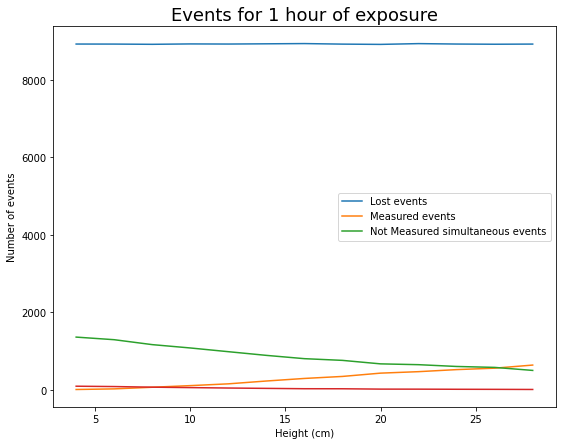

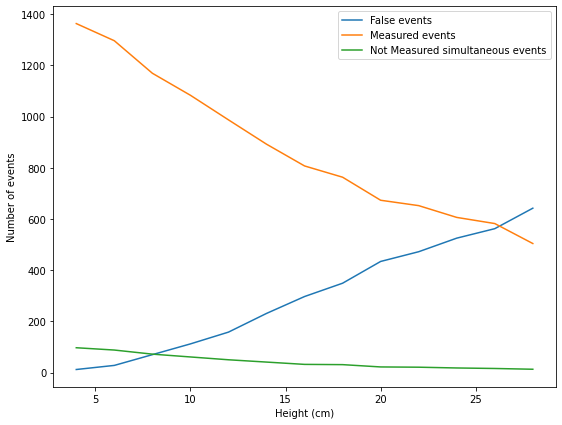

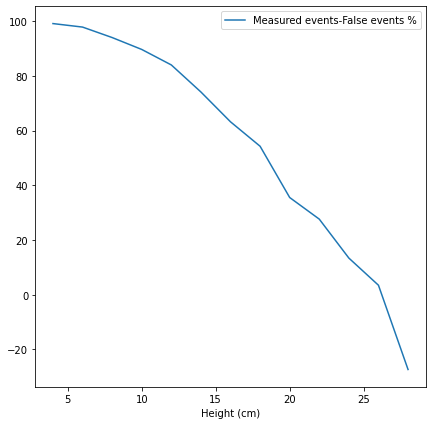

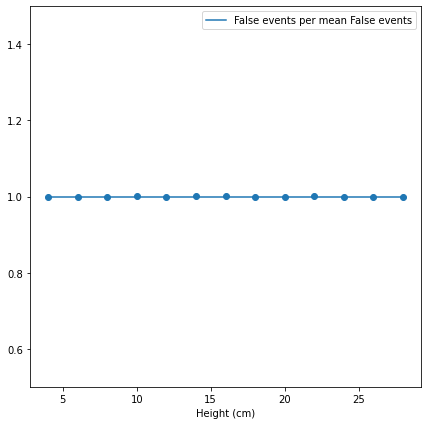

In [106]:
height2=np.arange(4,30,2)
plt.figure(figsize=(9, 7))
plt.plot(height2,results[:,0])
plt.plot(height2,results[:,1])
plt.plot(height2,results[:,2])
plt.plot(height2,results[:,3])
plt.title("Events for 1 hour of exposure" , fontsize=18)
plt.legend(["Lost events","Measured events","Not Measured simultaneous events"])
plt.xlabel("Height (cm)")
plt.ylabel("Number of events")
plt.show()

plt.figure(figsize=(9, 7))
plt.plot(height2,results[:,1])
plt.plot(height2,results[:,2])
plt.plot(height2,results[:,3])
plt.legend(["False events","Measured events","Not Measured simultaneous events"])
plt.xlabel("Height (cm)")
plt.ylabel("Number of events")
plt.show()

plt.figure(figsize=(7, 7))
plt.plot(height2,100*(results[:,2]-results[:,1])/results[:,2])
plt.legend(["Measured events-False events %"])
plt.xlabel("Height (cm)")
plt.show()

plt.figure(figsize=(7, 7))
plt.scatter(height2,results[:,0]/(results[:,0].sum()/13))
plt.ylim(0.5,1.5)
a=np.ones(13)
plt.plot(height2,a)
plt.legend(["False events per mean False events"])
plt.xlabel("Height (cm)")
plt.show()